# How convolutional neural networks see the world

Inspired by [Keras blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

## Define the VGG16 model in Keras

In [2]:
from keras import applications
from keras import backend as K

Using TensorFlow backend.


The imported model is already initialized with the weights from the ImageNet competition submission in 2014.

The top layers are removed as:
 * they are at an abstraction level specific to the problem;
 * their definition prevents the Convolutional layers from working with any input size.

In [3]:
model = applications.VGG16(include_top=False, weights='imagenet')

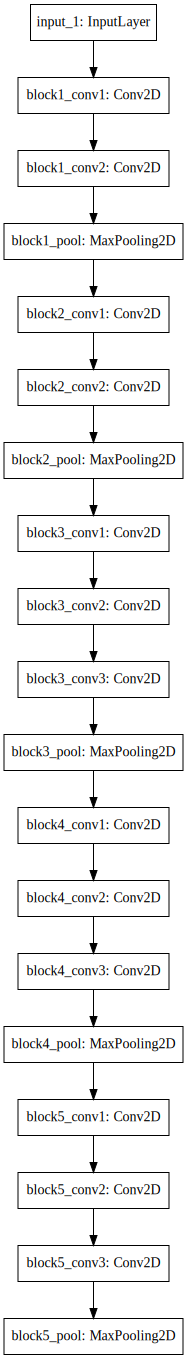

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

## 1<sup>st</sup> Task: What activates each layer's convolutional filters

### Set-up some needed configurations

Number of random filters selected per layer

In [9]:
nr_filters_per_layer = 3

The layers in which we will investigate the filters

In [10]:
layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

In [11]:
filter_indexes = [
    np.random.choice(range(layer_dict[layer_name].output.shape[3].value), nr_filters_per_layer)
    for layer_name in layer_names
]

### Prepare an input image with random noise

Neural network's input image placeholder

In [12]:
input_img = model.input

Function to generate an image with random noise

In [13]:
def generate_random_image(img_width=128, img_height=128):
    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    return input_img_data

Utilitary function to convert a tensor into a valid image

In [14]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Visualize a generated image

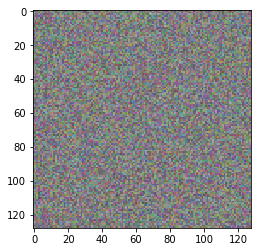

In [15]:
plt.imshow(deprocess_image(generate_random_image()[0]))

### Define optimization objective

In [16]:
layer_nr = 4
filter_nr = 2

Neural network's placeholder for layer's tensor

In [17]:
layer_output = layer_dict[layer_names[layer_nr]].output

Define the "loss" as being the average value of the desired filter in the selected layer

In [18]:
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer_output[:, filter_nr, :, :])
else:
    loss = K.mean(layer_output[:, :, :, filter_nr])

Compute the gradient of the input picture with respoct to this loss, *i.e.* the direction in which we can vary the input image in order to increase or decrease the "loss"

In [19]:
grads = K.gradients(loss, input_img)[0]

Normalize the gradients

In [20]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [21]:
grads = normalize(grads)

Function that returns the loss and gradients given the input picture

In [22]:
iterate = K.function([input_img], [loss, grads])

For a given number of iterations, modify the input image so we increase the activation at the desired filter:

In [23]:
input_img_data = generate_random_image()

In [24]:
step = 1.

In [25]:
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

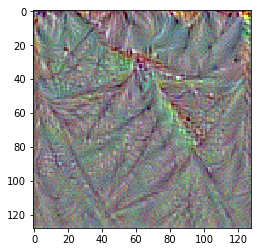

In [26]:
plt.imshow(deprocess_image(input_img_data[0]))

<img src="https://blog.keras.io/img/vgg16_filters_overview.jpg">

## Finding an input that maximizes a specific class

In [115]:
model = applications.VGG16(include_top=True,
                           weights='imagenet')

In [116]:
input_img = model.input

[ImageNet Labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

In [117]:
output_index = 65 # sea snake
loss = K.mean(model.output[:, output_index])

In [118]:
grads = K.gradients(loss, input_img)[0]

In [119]:
grads = normalize(grads)

In [120]:
iterate = K.function([input_img], [loss, grads])

In [121]:
input_img_data = generate_random_image(224, 224)

In [122]:
step = 10.

In [123]:
for _ in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * 10
    print(loss_value)

0.000345107
0.000376648
0.000412708
0.000458631
0.000525027
0.000628305
0.000809388
0.00114809
0.00224836
0.00934591
0.0352347
0.0153497
0.674567
0.00236891
0.47003
0.7306
0.0334229
0.992094
0.999502
0.999559


In [124]:
print(loss_value)

0.999559


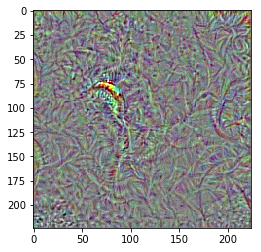

In [125]:
plt.imshow(deprocess_image(input_img_data[0]))